In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from scipy.linalg import eigh
from scipy.stats import multivariate_normal as gaussian
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import plda

C:\Users\risto\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [2]:
wine = load_wine()
seed=1
training_data, testing_data, training_labels, testing_labels=train_test_split(wine.data, wine.target, test_size=0.2, random_state=seed)

#training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
#training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

In [3]:
wine.data.shape, wine.target.shape

((178, 13), (178,))

In [4]:
training_data.shape, training_labels.shape

((142, 13), (142,))

In [5]:
testing_data.shape, testing_labels.shape

((36, 13), (36,))

In [6]:
#training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
#training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

In [7]:
#testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
#testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

## Helpers

In [8]:
def calc_scatter_matrices(X, Y):
    """ See Equations (1) on p.532 of Ioffe 2006. """
    assert len(X.shape) == 2
    assert X.shape[0] == len(Y)

    unique_labels = np.unique(Y)
    labels = np.asarray(Y)

    m = X.mean(axis=0)
    N = X.shape[0]

    cov_ks = []
    m_ks = []
    n_ks = []

    for k in unique_labels:
        bool_idxs = labels == k
        X_k = X[bool_idxs]

        m_ks.append(X_k.mean(axis=0))
        n_ks.append(bool_idxs.sum())

        cov_ks.append(np.cov(X_k.T))

    n_ks = np.asarray(n_ks)
    m_ks = np.asarray(m_ks)

    m_ks_minus_m = m_ks - m
    S_b = np.matmul(m_ks_minus_m.T * (n_ks / N), m_ks_minus_m)

    S_w = np.asarray(cov_ks) * ((n_ks - 1) / N)[:, None, None]
    S_w = np.sum(S_w, axis=0)

    return S_b, S_w


In [9]:
def calc_m(X):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    assert len(X.shape) == 2
    return X.mean(axis=0)

def calc_W(S_b, S_w):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    eigenvalues, eigenvectors = eigh(S_b, S_w)
    return eigenvectors

def calc_Lambda_b(S_b, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_b), W)

def calc_Lambda_w(S_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_w), W)

def calc_n_avg(Y):
    """ This is the \"hack\" suggested in Fig 2 on p.537 of Ioffe 2006. """
    unique = np.unique(Y)
    return len(Y) / unique.shape[0]

def calc_A(n_avg, Lambda_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    inv_W_T = np.linalg.inv(W.T)
    return inv_W_T * (n_avg / (n_avg - 1) * Lambda_w_diagonal) ** .5


def calc_Psi(Lambda_w, Lambda_b, n_avg):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    Lambda_b_diagonal = Lambda_b.diagonal()  # Should be diagonal matrix.
    Psi = (n_avg - 1) / n_avg * Lambda_b_diagonal / Lambda_w_diagonal
    Psi -= 1 / n_avg
    Psi[Psi <= 0] = 0

    return np.diag(Psi)

def get_relevant_U_dims(Psi):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    relevant_dims = np.squeeze(np.argwhere(Psi.diagonal() != 0))
    if relevant_dims.shape == ():
        relevant_dims = relevant_dims.reshape(1,)
    return relevant_dims

def optimize_maximum_likelihood(X, labels):
    """ Performs the optimization in Fig. 2 of p.537 of Ioffe 2006.

    DESCRIPTION
     - The main model parameters are `m`, `A`, and `Psi`.
     - However, to improve the performance (speed and numerical stability)
        of the plda.Model object,
        inv_A and relevant_U_dims are also returned here.

    ADDITIONAL NOTES
     Be sure to test that np.cov(X.T) is full rank before running this.

     Recall that there are 4 \"spaces\":
      'D' (data) <---> 'X' (preprocessed) <---> 'U' (latent) <---> 'U_model'

    ARGUMENTS
     X  (numpy.ndarray), shape=(n_data, n_dimensions)
       - Data in statistics format, i.e. row-wise.

     labels  (list or numpy.ndarray), length=X.shape[0]
       - Labels for the data in `X`.
       - Must be sorted in the same order as `X`.

    RETURNS
     m  (numpy.ndarray), shape=X.shape[-1]
       - The mean of the row vectors in X.
       - This is the prior mean fitted via maximum likelihood.

     A  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - Transformation from X space to the latent U space.

     Psi  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - The covariance matrix of the prior distribution on
          the category means in U space.

     relevant_U_dims  (numpy.ndarray), shape=(len(np.unique(labels)) - 1,)
       - The \"effective\" latent dimensions,
          i.e. the ones that are actually used by the model.

     inv_A  (numpy.ndarray), shape=A.shape
       - The inverse of the matrix A.
       - Transformation from the latent U space to the X space.
    """
    assert len(X.shape) == 2
    assert X.shape[0] == len(labels)

    m = X.mean(axis=0)

    S_b, S_w = calc_scatter_matrices(X, labels)
    W = calc_W(S_b, S_w)

    Lambda_b = calc_Lambda_b(S_b, W)
    Lambda_w = calc_Lambda_w(S_w, W)
    n_avg = calc_n_avg(labels)

    A = calc_A(n_avg, Lambda_w, W)
    inv_A = np.linalg.inv(A)

    Psi = calc_Psi(Lambda_w, Lambda_b, n_avg)
    relevant_U_dims = get_relevant_U_dims(Psi)

    return m, A, Psi, relevant_U_dims, inv_A



## Calculate

In [10]:
data=training_data
labels=training_labels
n_principal_components=3

In [11]:
data.shape

(142, 13)

In [12]:
len(labels)

142

#### Scatte matrices (not needed if n_principal components set)

In [13]:
S_b, S_w = calc_scatter_matrices(data, labels)
matrix_rank = np.linalg.matrix_rank(S_w)

In [14]:
#S_b

In [15]:
#S_w

In [16]:
matrix_rank

13

well set it to n_components not to overlearn

In [17]:
matrix_rank=n_principal_components

#### PCA

In [18]:
pca = PCA(n_components=matrix_rank)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### transform

In [19]:
# X = self.transform(data, from_space='D', to_space='X')

X=pca.transform(data)
#X=data

In [20]:
X.shape

(142, 3)

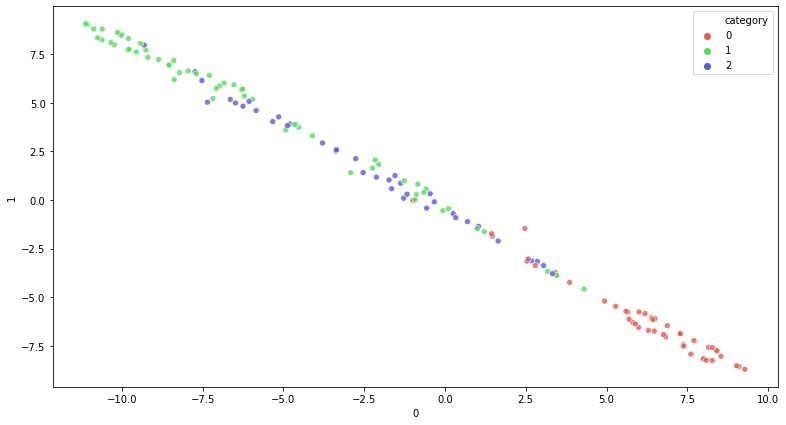

In [21]:
#plot transformed features
#use tsne to get 2 dim
X_tsne = TSNE(n_components=2).fit_transform(X)

df_tsne = pd.DataFrame(X_tsne)
df_tsne.columns = [str(c) for c in df_tsne.columns]
df_tsne['category'] = training_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x="0", y="1",
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

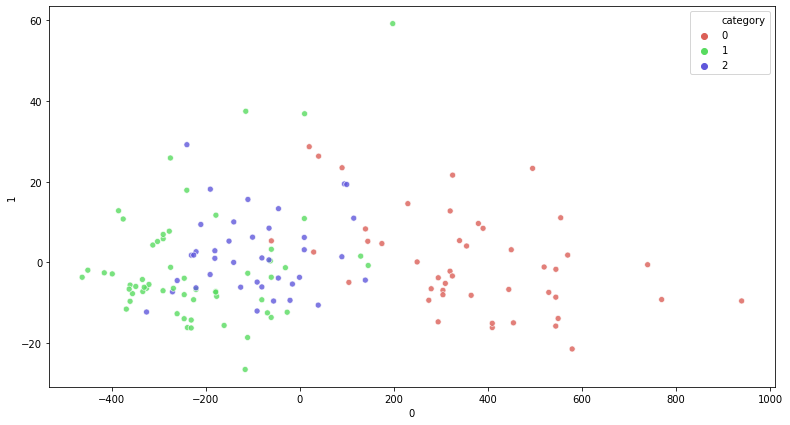

In [22]:
#plot pca features, if only 2-dim
pca_2dim = PCA(n_components=2)
pca_2dim.fit(data)
X_2dim=pca_2dim.transform(data)
df_x2dim=pd.DataFrame(X_2dim)
df_x2dim['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_x2dim,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### learn params

In [23]:
m, A, Psi, relevant_U_dims, inv_A = optimize_maximum_likelihood(X, labels)

In [24]:
m

array([2.56195691e-14, 5.69184762e-15, 5.20983882e-15])

In [25]:
A

array([[ 1.84489059e+01, -4.42685021e+01, -1.54801490e+02],
       [-1.23141262e+01, -2.61292942e+00, -1.36302888e-01],
       [-7.08717991e-01,  2.63048726e+00, -2.85885986e-01]])

In [26]:
Psi

array([[0.        , 0.        , 0.        ],
       [0.        , 0.2633962 , 0.        ],
       [0.        , 0.        , 2.61352107]])

In [27]:
relevant_U_dims

array([1, 2], dtype=int64)

In [28]:
inv_A

array([[ 2.02000042e-04, -7.67148457e-02, -7.28033323e-02],
       [-6.25588536e-04, -2.10095431e-02,  3.48760358e-01],
       [-6.25691299e-03, -3.13462078e-03, -1.08411363e-01]])

#### transfrom X from space X to U_model

In [29]:
relevant_U_dims

array([1, 2], dtype=int64)

In [30]:
#from X -> U
x_in_u=np.matmul(X - m, inv_A.T)

U_model=x_in_u[..., relevant_U_dims]
U_model.round(3)[0]

array([0.035, 1.936])

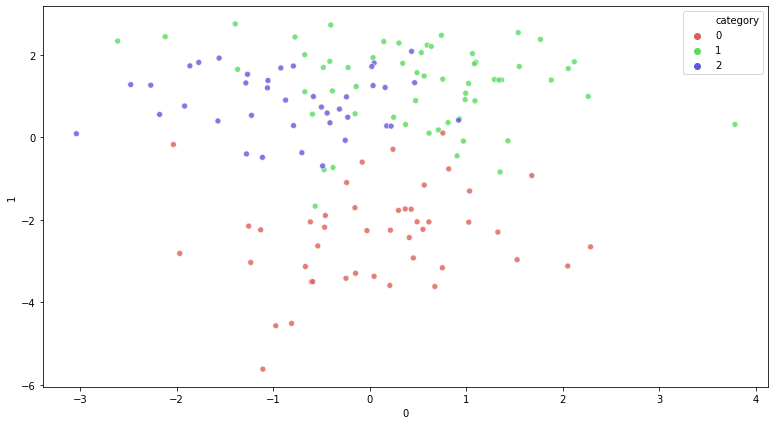

In [31]:
#U_dim
df_udim_model=pd.DataFrame(U_model)
df_udim_model['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_udim_model,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### get prior params

In [32]:
cov_diag = Psi.diagonal()[relevant_U_dims]
mean = np.zeros(relevant_U_dims.shape)

prior_params= {'mean': mean, 'cov_diag': cov_diag}
mean

array([0., 0.])

In [33]:
cov_diag

array([0.2633962 , 2.61352107])

In [34]:
Psi.diagonal()

array([0.        , 0.2633962 , 2.61352107])

#### get posterior params

In [35]:
labels = np.asarray(labels)
prior_cov_diagonal = prior_params['cov_diag']

cov_diags = []
means = []
categories = []

for k in np.unique(labels):
#     print(k)
    bool_idxs = labels == k
    U_model_k = U_model[bool_idxs]
    n_k = bool_idxs.sum()

    cov_diag = prior_cov_diagonal / (1 + n_k * prior_cov_diagonal)
    mean = U_model_k.sum(axis=0) * cov_diag

    cov_diags.append(cov_diag)
    means.append(mean)
    categories.append(k)

    #add them to dict
posterior_params = dict()
for label, mean, cov_diag in zip(categories, means, cov_diags):
    category_params = dict()
    category_params['mean'] = mean
    category_params['cov_diag'] = cov_diag

    posterior_params[label] = category_params

In [36]:
posterior_params

{0: {'mean': array([ 0.07163113, -2.35134876]),
  'cov_diag': array([0.02049325, 0.02203486])},
 1: {'mean': array([0.46043557, 1.2515773 ]),
  'cov_diag': array([0.01618213, 0.01712838])},
 2: {'mean': array([-0.74652464,  0.85418408]),
  'cov_diag': array([0.02336636, 0.02539191])}}

#### get posterior_predictive_params

In [37]:
posterior_predictive_params = posterior_params.copy()

for k, k_params in posterior_predictive_params.items():
    k_params['cov_diag'] += 1

In [38]:
posterior_predictive_params

{0: {'mean': array([ 0.07163113, -2.35134876]),
  'cov_diag': array([1.02049325, 1.02203486])},
 1: {'mean': array([0.46043557, 1.2515773 ]),
  'cov_diag': array([1.01618213, 1.01712838])},
 2: {'mean': array([-0.74652464,  0.85418408]),
  'cov_diag': array([1.02336636, 1.02539191])}}

## Predict on new data

#### transform from D to U_model

In [39]:
data_temp=pca.transform(testing_data)
data_temp=np.matmul(data_temp - m, inv_A.T)
testing_data_transformed=data_temp[..., relevant_U_dims]

In [40]:
testing_data_transformed.shape

(36, 2)

In [41]:
testing_data_transformed[0]

array([-0.34463147,  0.4083779 ])

In [42]:
testing_data_transformed[1]

array([0.01796129, 2.38279116])

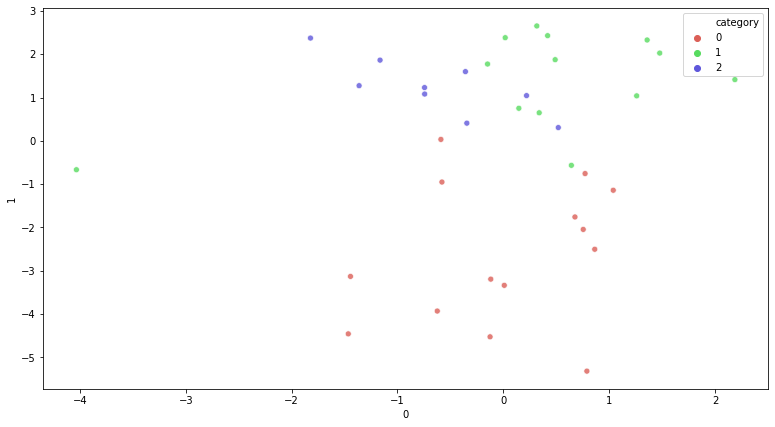

In [43]:
#testing_data_transformed
df_testing_data_transformed=pd.DataFrame(testing_data_transformed)
df_testing_data_transformed['category']=testing_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_testing_data_transformed,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### calculate logprobs per category

In [44]:
def calc_logp_posterior_predictive( U_model, category):
    mean = posterior_predictive_params[category]['mean']
    cov_diag = posterior_predictive_params[category]['cov_diag']

    return gaussian(mean, np.diag(cov_diag)).logpdf(U_model)

In [45]:
logpps_by_category = []
K =  [k for k in posterior_params.keys()]

for k in K:
    logpps_k = calc_logp_posterior_predictive(testing_data_transformed, k)
    logpps_by_category.append(logpps_k)

logpps_by_category = np.stack(logpps_by_category, axis=-1)

logps = logpps_by_category
K=np.asarray(K)

In [46]:
logps[1]

array([-12.82476965,  -2.57977574,  -3.286899  ])

In [47]:
len(logps)

36

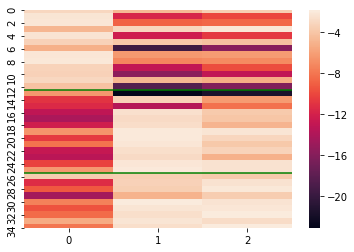

In [48]:
#sorted by the labels
sorted_test_labels=np.sort(testing_labels)
sort_idx=np.argsort(testing_labels)
ax=sns.heatmap(logps[sort_idx,])
ax.hlines(np.where(sorted_test_labels[:-1] != sorted_test_labels[1:])[0], *ax.get_xlim(), color='green')

#### get highest logprob

In [49]:
predictions = K[np.argmax(logps, axis=-1)]

In [50]:
predictions

array([2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1])

In [51]:
print(classification_report(testing_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.86      0.92      0.89        13
           2       0.78      0.78      0.78         9

    accuracy                           0.89        36
   macro avg       0.88      0.88      0.88        36
weighted avg       0.89      0.89      0.89        36



## Visualize

#### original testing data

In [52]:
def plot_tsne(x, y, n_components=2):
    X_tsne = TSNE(n_components=2).fit_transform(x)

    df_tsne = pd.DataFrame(X_tsne)
    df_tsne.columns = [str(c) for c in df_tsne.columns]
    df_tsne['category'] = y

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="0", y="1",
        hue="category",
#         palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
        data=df_tsne,
        legend="full",
        alpha=0.7
    )
    plt.setp(ax.get_legend().get_texts(), fontsize='22')  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='25')  # for legend title

#### original testing data

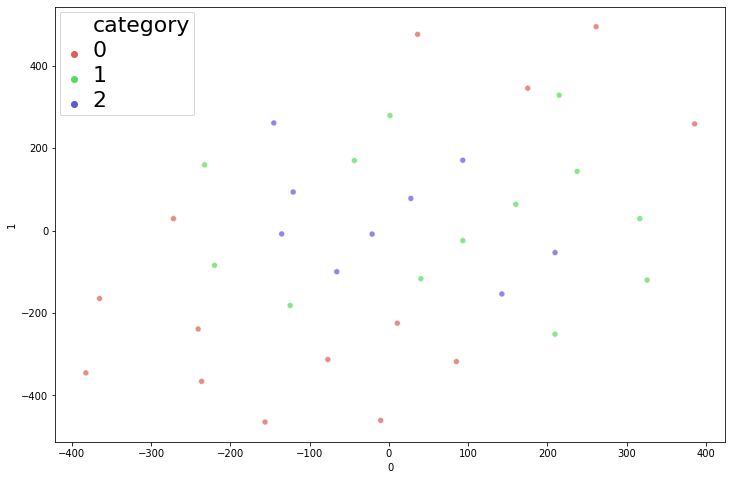

In [53]:
plot_tsne(testing_data, testing_labels)

#### transformed testing data

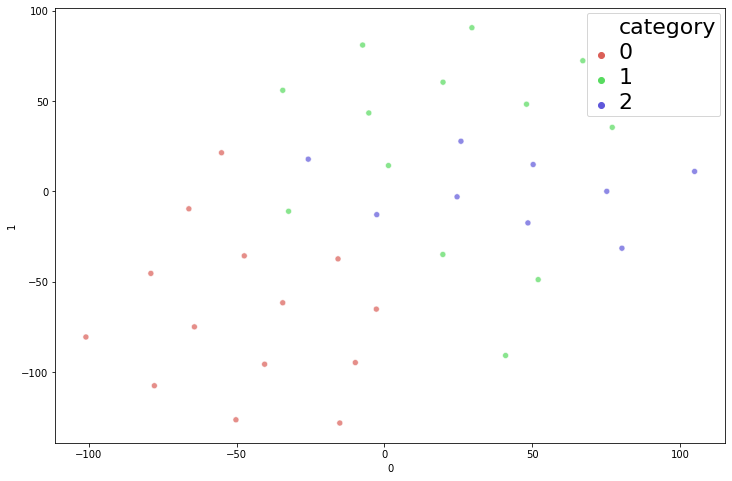

In [54]:
plot_tsne(testing_data_transformed, testing_labels)

#### Compare with LDA

In [55]:
clf = LinearDiscriminantAnalysis(n_components=5)
clf.fit(training_data, training_labels)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(13, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=5, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [56]:
lda_transformed_testdata=clf.transform(testing_data)

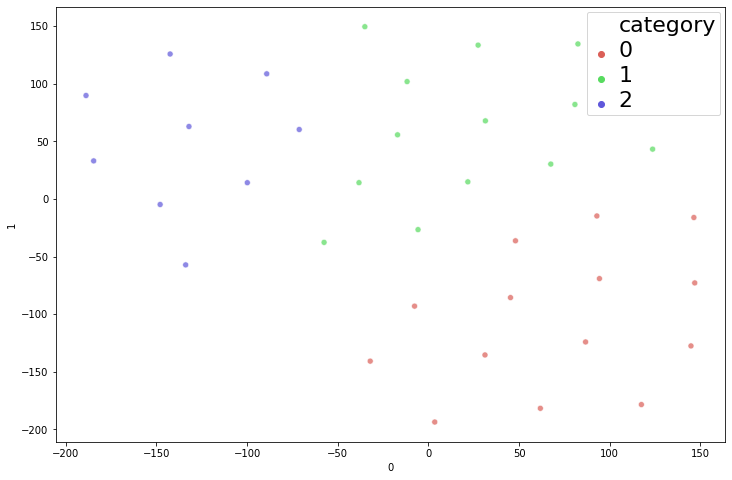

In [57]:
plot_tsne(lda_transformed_testdata, testing_labels)

## Classification lda, pca, plda

In [117]:
f1=[]
f1_pca=[]
f1_lda=[]
f1_plda=[]
for seed in range(50):
    #without lda
    X_train, X_test, y_train, y_test=train_test_split(wine.data, wine.target, test_size=0.3, random_state=seed)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

    pipe.fit(X_train, y_train)
    pred=pipe.predict(X_test)
    f1.append((f1_score(y_test, pred, average='micro')))
    
    #with pca
    pipe_pca = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
    pca=PCA(n_components=2)
    X_train_pca=pca.fit_transform(X_train, y_train)
    X_test_pca=pca.transform(X_test)
    pipe_pca.fit(X_train_pca, y_train)
    pred_pca=pipe_pca.predict(X_test_pca)
    f1_pca.append(f1_score(y_test, pred_pca, average='micro'))
    
    #with lda
    pipe_lda = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

    lda=LinearDiscriminantAnalysis()
    X_train_lda=lda.fit_transform(X_train, y_train)
    X_test_lda=lda.transform(X_test)

    pipe_lda.fit(X_train_lda, y_train)
    pred_lda=pipe_lda.predict(X_test_lda)
    f1_lda.append(f1_score(y_test, pred_lda, average='micro'))
    
    #with plda
    better_classifier = plda.Classifier()
    better_classifier.fit_model(X_train, y_train, n_principal_components=13)
    pred_plda, log_p_predictions = better_classifier.predict(X_test)
    f1_plda.append(f1_score(y_test, pred_plda, average='micro'))

In [118]:
print(np.mean(f1))

0.9777777777777777


In [119]:
print(np.mean(f1_pca))

0.6603703703703704


In [120]:
print(np.mean(f1_lda))

0.9848148148148148


In [121]:
print(np.mean(f1_plda))

0.9825925925925927


## Classifiy mnist data

In [123]:
training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

In [128]:
training_data.shape, testing_data.shape

((200, 784), (100, 784))

In [140]:
data_all=np.append(training_data, testing_data, axis=0)
all_labels=np.append(training_labels, testing_labels)
data_all.shape, all_labels.shape

((300, 784), (300,))

In [193]:
f1s=[]
f1_pcas=[]
f1_ldas=[]
f1_pldas=[]
n_comps=[]
seeds=[]
# n_components=50
for n_components in range(10, 100, 10):
#     f1=[]
#     f1_pca=[]
#     f1_lda=[]
#     f1_plda=[]
    for seed in range(50):
        #without lda
        X_train, X_test, y_train, y_test=train_test_split(data_all, all_labels, test_size=0.3, random_state=seed)
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

        pipe.fit(X_train, y_train)
        pred=pipe.predict(X_test)
        f1s.append((f1_score(y_test, pred, average='micro')))

        #with pca
        pipe_pca = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
        pca=PCA(n_components=n_components)
        X_train_pca=pca.fit_transform(X_train, y_train)
        X_test_pca=pca.transform(X_test)
        pipe_pca.fit(X_train_pca, y_train)
        pred_pca=pipe_pca.predict(X_test_pca)
        f1_pcas.append(f1_score(y_test, pred_pca, average='micro'))

        #with lda
        pipe_lda = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

        lda=LinearDiscriminantAnalysis(n_components=n_components)
        X_train_lda=lda.fit_transform(X_train, y_train)
        X_test_lda=lda.transform(X_test)

        pipe_lda.fit(X_train_lda, y_train)
        pred_lda=pipe_lda.predict(X_test_lda)
        f1_ldas.append(f1_score(y_test, pred_lda, average='micro'))

        #with plda
        better_classifier = plda.Classifier()
        better_classifier.fit_model(X_train, y_train, n_principal_components=n_components)
        pred_plda, log_p_predictions = better_classifier.predict(X_test)
        f1_pldas.append(f1_score(y_test, pred_plda, average='micro'))
        
        seeds.append(seed)
        n_comps.append(n_components)


C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

In [196]:
df_comparison=pd.DataFrame({'n_comps':n_comps, 'seed':seeds, 'orig':f1s, 'pca':f1_pcas,
                           'lda':f1_ldas, 'plda':f1_pldas})

C:\Users\risto\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:375: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2F02CDE08>,
      dtype=object)

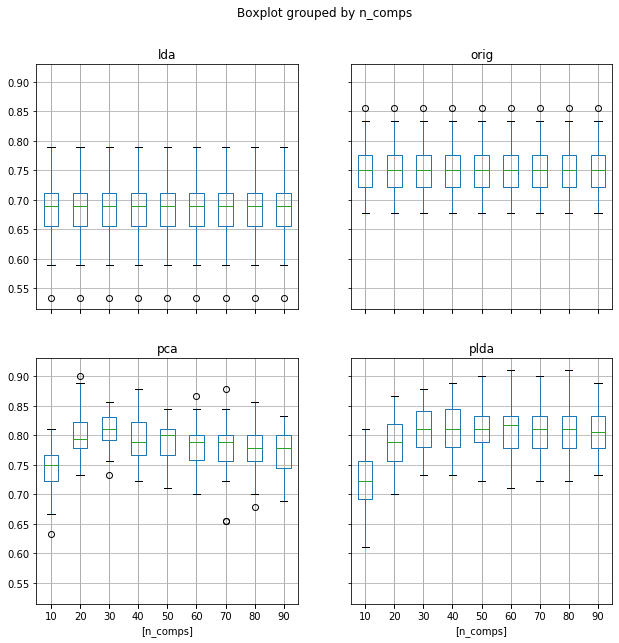

In [201]:
fig, ax =plt.subplots(figsize=(10,10))
df_comparison[['n_comps','orig','pca','lda','plda']].boxplot(by='n_comps', ax=ax)

In [202]:
df_comparison[['n_comps','orig','pca','lda','plda']].groupby('n_comps').mean()

,orig,pca,lda,plda
n_comps,,,,
10,0.749778,0.743778,0.683556,0.725333
20,0.749778,0.799556,0.683556,0.786889
30,0.749778,0.810000,0.683556,0.810889
40,0.749778,0.794000,0.683556,0.817556
50,0.749778,0.790000,0.683556,0.808444
60,0.749778,0.781556,0.683556,0.808000
70,0.749778,0.780444,0.683556,0.804000
80,0.749778,0.775556,0.683556,0.806889
90,0.749778,0.773111,0.683556,0.803333


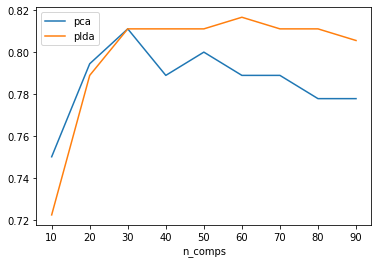

In [205]:
df_comparison[['n_comps','orig','pca','lda','plda']].groupby('n_comps').median()[['pca', 'plda']].plot()